- The following code uses daily data of closing prices from european markets to calculate and plot the daily returns.
- It also used a European Uncertainty index as an independed variable in the model. More information on this variable can be found here https://www.policyuncertainty.com/.
- Then for each country , checks the returns for stationarity, standarizes the data and fits a GARCH (1,1) model using and ARX model as the mean model.
- Then it calculates the AIC and BIC information criteria for each , conducts a  Ljung-Box test to test for autocorrelation in the residuals and plots the   the fitted conditional volatility from the GARCH model.

- Important Notes:
  
   All the data has been cleaned before hand ensuring no missing values using linear interpolation. The frequency of the european uncertainty inded was matched to that of the daily closing price data (daily).

  This code only showcases the case of Austria, but the same analysis can be conducted for the rest of the 13 european countries as well. 
  

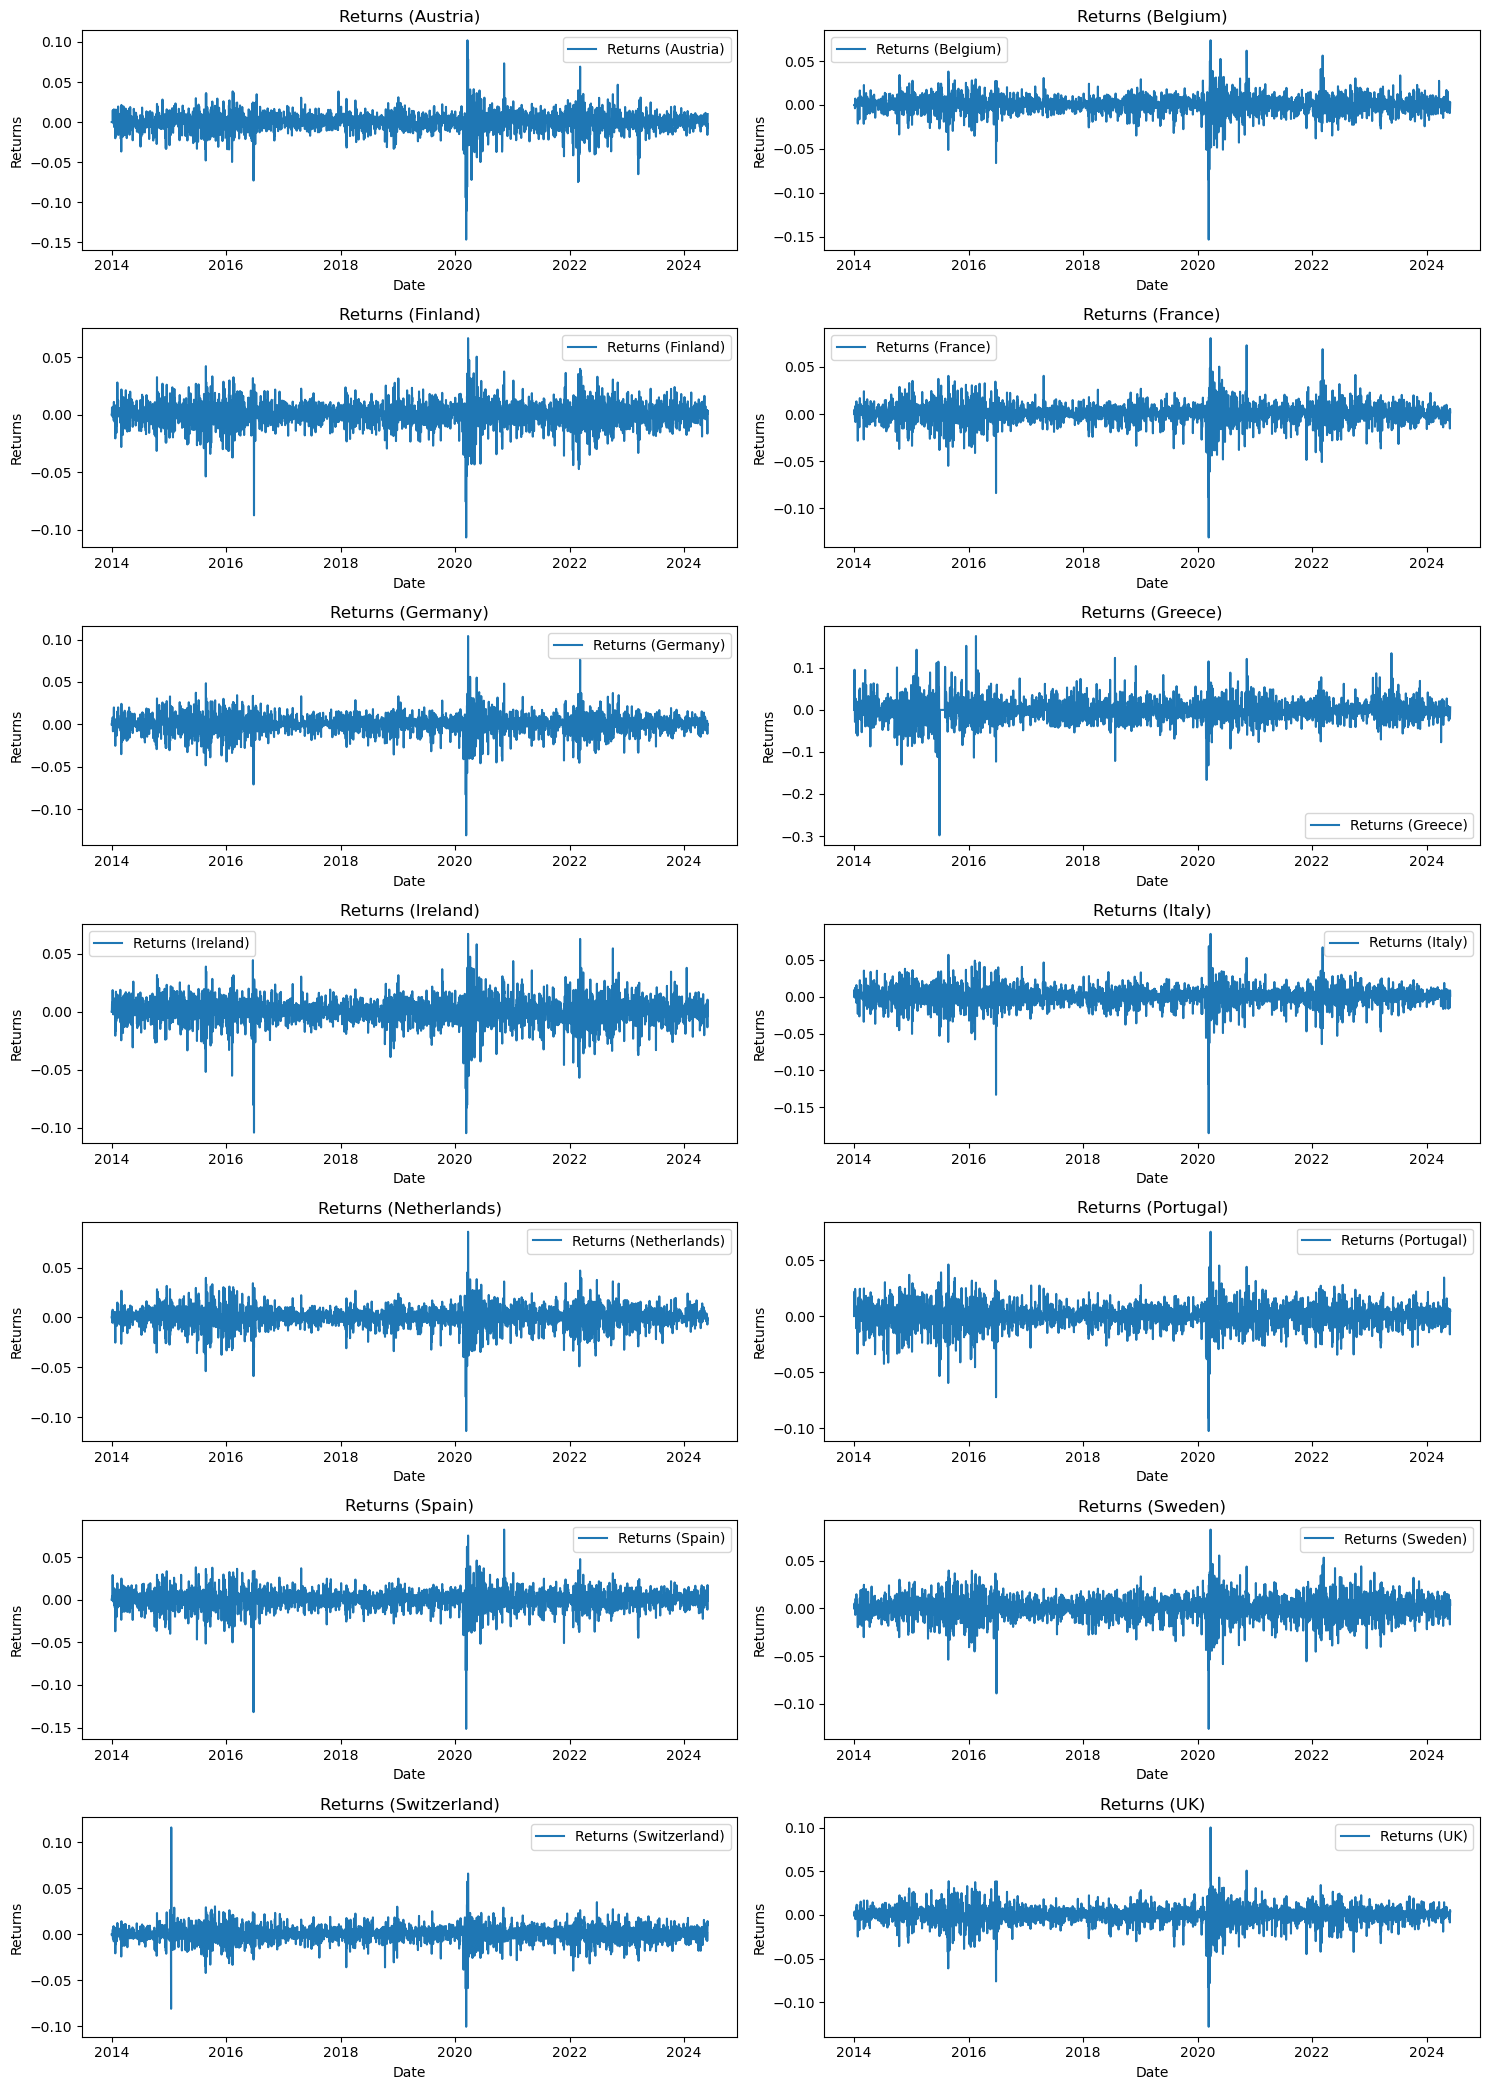

In [7]:
import pandas as pd
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf, q_stat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from scipy.stats import jarque_bera

# Load your data
data = pd.read_excel('EUROPEAN RETURNS AND UNCERTAINTY GARCH.xlsx', parse_dates=['date'], index_col='date')

# Set frequency of the date index
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

# Select the returns series for different countries
returns_austria = data['returns_austria']
returns_belgium = data['returns_belgium']
returns_finland = data['returns_finland']
returns_france = data['returns_france']
returns_germany = data['returns_germany']
returns_greece = data['returns_greece']
returns_ireland = data['returns_ireland']
returns_italy = data['returns_italy']
returns_netherlands = data['returns_netherlands']
returns_portugal = data['returns_portugal']
returns_spain = data['returns_spain']
returns_sweden = data['returns_sweden']
returns_switzerland = data['returns_switzerland']
returns_uk = data['returns_uk']

# Select the EUI (uncertainty index) series
eui = data['EUI']

# Select the returns series for different countries
returns = {
    'Austria': data['returns_austria'],
    'Belgium': data['returns_belgium'],
    'Finland': data['returns_finland'],
    'France': data['returns_france'],
    'Germany': data['returns_germany'],
    'Greece': data['returns_greece'],
    'Ireland': data['returns_ireland'],
    'Italy': data['returns_italy'],
    'Netherlands': data['returns_netherlands'],
    'Portugal': data['returns_portugal'],
    'Spain': data['returns_spain'],
    'Sweden': data['returns_sweden'],
    'Switzerland': data['returns_switzerland'],
    'UK': data['returns_uk']
}

# Plot returns to visualize their stationarity
num_countries = len(returns)
num_cols = 2
num_rows = (num_countries + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()

for i, (country, return_series) in enumerate(returns.items()):
    axes[i].plot(return_series, label=f'Returns ({country})')
    axes[i].set_title(f'Returns ({country})')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Returns')
    axes[i].legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


ADF Statistic: -15.686855
p-value: 0.000000
Series is stationary
Iteration:      5,   Func. Count:     64,   Neg. LLF: 7564.489518438771
Iteration:     10,   Func. Count:    119,   Neg. LLF: 4872.933237210411
Iteration:     15,   Func. Count:    167,   Neg. LLF: 4777.474283102698
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4777.474142440089
            Iterations: 17
            Function evaluations: 185
            Gradient evaluations: 17
AIC Austria: 9570.948284880178
BIC Austria: 9620.892440632093
                          AR-X - GARCH Model Results                          
Dep. Variable:        returns_austria   R-squared:                       0.002
Mean Model:                      AR-X   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -4777.47
Distribution:                  Normal   AIC:                           9570.95
Method:            Maximum Likelihood   BIC:        

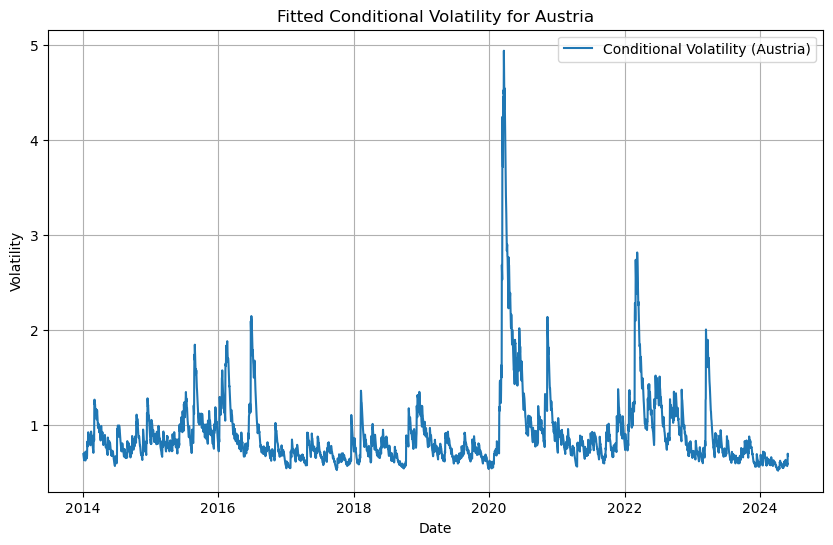

In [9]:
#austria

# Ensure data is stationary
result_austria = adfuller(returns_austria.dropna())
print('ADF Statistic: %f' % result_austria[0])
print('p-value: %f' % result_austria[1])
if result_austria[1] > 0.05:
    print('Series is not stationary, differencing the series.')
    returns_austria = returns_austria.diff().dropna()
    result_austria = adfuller(returns_austria.dropna())
    print('ADF Statistic after differencing: %f' % result_austria[0])
    print('p-value after differencing: %f' % result_austria[1])
    if result_austria[1] > 0.05:
        print('Differenced series is not stationary, consider further differencing or other transformations.')
    else:
        print('Differenced series is stationary')
else:
    print('Series is stationary')
    
# Standardize the returns and the EUI series
mean_returns_austria = returns_austria.mean()
std_returns_austria = returns_austria.std()
returns_austria_standardized = (returns_austria - mean_returns_austria) / std_returns_austria

mean_eui = eui.mean()
std_eui = eui.std()
eui_standardized = (eui - mean_eui) / std_eui

# Prepare the lagged returns and EUI as exogenous variables
lagged_returns_austria = pd.concat([returns_austria_standardized.shift(i) for i in range(1, 4)], axis=1)
lagged_returns_austria.columns = [f'lag_{i}' for i in range(1, 4)]
lagged_returns_austria = lagged_returns_austria.dropna()

# Align the EUI data
eui_standardized = eui_standardized.loc[lagged_returns_austria.index]

# Combine lagged returns and EUI
exog_variables = pd.concat([lagged_returns_austria, eui_standardized], axis=1)
exog_variables = exog_variables.dropna()

# Align the returns data with the exogenous variables
returns_austria_standardized = returns_austria_standardized.loc[exog_variables.index]

# Fit the GARCH(1, 1) model using the ARX model for the mean
model_austria = arch_model(returns_austria_standardized, p=1, q=1, mean='ARX', x=exog_variables)
model_fit_austria = model_austria.fit(update_freq=5)

# Extract AIC and BIC from the fitted model
aic_austria = model_fit_austria.aic
bic_austria = model_fit_austria.bic

print(f"AIC Austria: {aic_austria}")
print(f"BIC Austria: {bic_austria}")

# Output the summary of the model fit
print(model_fit_austria.summary())

# Check residuals
residuals = model_fit_austria.resid

# Ljung-Box Test
ljung_box_results = q_stat(acf(residuals, fft=True, nlags=40)[1:], len(residuals))
p_values = ljung_box_results[1]

print("Ljung-Box test p-values:")

# Check for white noise (no significant autocorrelation)
if all(p_values > 0.05):
    print("Residuals appear to be white noise.")
else:
    print("Residuals may have significant autocorrelation.")

# Save the fitted values of the conditional volatility
fitted_volatility_austria = model_fit_austria.conditional_volatility
fitted_volatility_austria.to_excel('fitted_volatility_austria.xlsx')

# Plot the fitted conditional volatility
plt.figure(figsize=(10, 6))
plt.plot(fitted_volatility_austria, label='Conditional Volatility (Austria)')
plt.title('Fitted Conditional Volatility for Austria')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()
